# Caso real: predicción de demanda eléctrica en Uruguay

*   [Introducción al problema](#intro)
*   [Lectura de los datos](#lectura)
*   [Visualización previa exploratoria](#visualizacion)
*   [Preprocesamiento](#preprocesamiento)
*   [Modelado](#modelado)
*   [Evaluación](#evaluacion)


<a id="intro"></a>
# Introducción

## Predicción de demanda eléctrica

Los sistemas eléctricos están en constante funcionamiento. Sistemas, plantas, conexiones, se apagan y prenden, abren y cierran diariamente para ajustarse a la demanda de electricidad del país en su totalidad. 

Por diversos motivos, lo anterior no puede hacerse de manera instantánea, sino que requiere cierta previsión. Es por eso que prever la demanda del sistema con cierta antelación, usualmente de un día para el otro, es crucial para un buen funcionamiento del sistema eléctrico. Este es un problema que se da en todo el mundo, no sólo en Uruguay.

La demanda eléctrica se mide en MWh (millones de Watts-hora). Cabe mencionar que un watt-hora es una medida de _energía_, tal como el Joule (no de potencia instantánea, como lo es el Watt). Para fijar ideas, un Watt-hora equivale a la energía consumida durante una hora por un aparato cuya potencia instantánea es 1 watt. Por ejemplo, una bombita de luz de 25 watts, prendida durante 1 hora, consume 25 watts-hora. Esa misma bombita, prendida durante 4 horas, consume 100 watts-hora, etc. 

Esa es la unidad en que vienen nuestras facturas de UTE.

## Antecedentes 

El siguiente trabajo fue realizado junto con colegas del Instituto de Estadística de UdelaR (IESTA) en un proyecto del Fondo Sectorial de Energía de 2013 (FSE 2013). Los resultados de ese trabajo están publicados en [[CCMR2018]](#CCMR2018).

## Planteo del problema

El tipo de problema al que nos enfrentamos es de _predicción_. Si bien es un problema clásico de estadística, procesamiento de señales, y análisis de series temporales, en la jerga de Aprendizaje Automático se ha dado a llamar a este tipo de problemas _autosupervisados_ (self supervised). La razón es la siguiente: son problemas en los que el entrenamiento tiene un objetivo bien definido, que es acertar (predecir) con la mayor exactitud a las muestras futuras de la serie de datos. Durante el entrenamiento, el sistema tiene como entrada las muestras pasadas, y su salida se compara con las muestras futuras de una serie de entrenamiento _ya conocida de antemano_. Es decir, los propios datos hacen las veces de entrada al sistema, y de salida de referencia, y es por eso que es "autosupervisado".

## Escenario

En el caso concreto de predicción de demanda que nos atañe, debemos predecir la demanda del día siguiente, que no es un sólo dato sino 144 (son 10 datos por hora), a partir de los datos disponibles hasta cierta hora del día actual.

Los datos de que disponemos son variados: para empezar, tenemos la serie de demandas efectivamente registradas hasta el día actual. Además, tenemos medidas de presión, temperatura, humedad, y radiación solar del día actual, y predicciones para el día siguiente. Finalmente, tenemos información de calendario, incluyendo si es un feriado o no. Como veremos más adelante, toda esta información puede ser relevante para predecir la demanda del día siguiente.



In [5]:
!wget -c  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre1.csv.gz
!wget -c  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre2.csv.gz
!wget -c  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre3.csv.gz
!wget -c  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre4.csv.gz
#
# preámbulo
#
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import numpy.random as rng

import os
import pandas as pd

mpl.rcParams['figure.dpi']  = 100
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size']        = 10
mpl.rcParams['legend.fontsize']  = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

#
# DATOS?
#
#https://www.kaggle.com/adityakadiwal/water-potability

--2022-10-25 14:31:15--  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre1.csv.gz
Resolving iie.fing.edu.uy (iie.fing.edu.uy)... 164.73.32.20
Connecting to iie.fing.edu.uy (iie.fing.edu.uy)|164.73.32.20|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-10-25 14:31:16--  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre2.csv.gz
Resolving iie.fing.edu.uy (iie.fing.edu.uy)... 164.73.32.20
Connecting to iie.fing.edu.uy (iie.fing.edu.uy)|164.73.32.20|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-10-25 14:31:16--  http://iie.fing.edu.uy/~nacho/data/energia/demanda_2007_2012_pre3.csv.gz
Resolving iie.fing.edu.uy (iie.fing.edu.uy)... 164.73.32.20
Connecting to iie.fing.edu.uy (iie.fing.edu.uy)|164.73.32.20|:80... connected.
HTTP request sent, aw

<a id="lectura"></a>
## Lectura

Los datos están en formato CSV (Comma Separated Value), una forma muy sencilla pero efectiva de almacenar tablas de datos.

Para ahorrar espacio, los archivos están comprimidos con el formato `gzip`; esto se denota por su extensión `.gz`.  El _gzip_  es un pariente del popular formato _zip_ que tiene soporte nativo en todos los sistemas operativos más comunes, lo que lo hace una buena elección desde el punto de vista de la _portabilidad_  de los datos, y por ende de la reproducibilidad de los experimentos.

Los archivos CSV se organizan en _filas_. Cada fila se lee como una tupla (lista) de $n$ elementos, donde $n$ es la cantidad de columnas de la tabla.

Python ya incluye funciones básicas para leer este tipo de datos a través del módulo `csv`. Este módulo es bastante flexible, pero requiere un poco de programación. 

Como alternativa, el paquete `pandas` ya incluye funciones para leer archivos CSV enteros dentro de estructuras `DataFrame` de Pandas. Además, Pandas facilita mucho la interpretación del contenido de los archivos. Vayamos entonces por ese camino.




In [6]:
import csv
import gzip
import pandas as pd

# mode='rt' indica 2 cosas: 
# -la 'r' indica 'read' (abrir para lectura) 
# -la 't' indica 'abrir como texto'
#
with gzip.open('demanda_2007_2012_pre1.csv.gz',mode='rt') as gzfile:
  #
  # las columnas del archivo CSV están separadas por caracteres tabuladores('tab')
  # que se escriben con el código '\t'
  #
  # además, sabemos que los datos inválidos en el archivo (por ej., temperaturas que no pudieron
  # ser medidas), tienen valor -100.00. Eso se lo indicamos a Pandas con el parámetro 'na_values'
  #
  dem_data = pd.read_csv(gzfile,delimiter='\t',na_values=('-100.00'))
#
# inspeccionemos las primeras filas
#
dem_data.head()
#
# convirtamos el archivo a una matriz numérica; esto nos facilitará imprimir
# (esto nos puede venir bien más tarde)


,#YEAR,MON,DAY,ISOYEAR,ISOWEEK,ISODAY,HOUR,MIN,HOLIDAY,TEMP,RAD,AVGDEM,TEMPOK,RADOK,DEMOK
0,2007,1,1,2007,1,1,0,0,1,NaN,NaN,NaN,0,0,0
1,2007,1,1,2007,1,1,0,10,1,26.52,0.0,991.0,1,1,1
2,2007,1,1,2007,1,1,0,20,1,-200.00,0.0,981.8,0,1,1
3,2007,1,1,2007,1,1,0,30,1,26.30,0.0,981.0,1,1,1
4,2007,1,1,2007,1,1,0,40,1,26.02,0.0,976.5,1,1,1


<a id="visualizacion"></a>
## Visualización

Los datos que tenemos son series temporales de demanda de energía junto con otros datos de utilidad para realizar la predicción. Concretamente, cada fila del archivo contiene los siguientes campos:

1.  año
1.  mes
1.  dia
1.  año ISO (International Standards Organization)
1.  semana ISO 
1.  dia    ISO
1.  hora
1.  minuto
1.  feriado (1 si es feriado, 0 si no)
1.  temperatura
1.  índice de radiación solar
1.  demanda promedio en MWh durante los últimos 10 minutos
1.  temperatura válida? (1: sí, 0: no)
1.  radiación válida? 
1.  demanda válida?

Los primeras 8 datos tienen que ver con el tiempo (no hay lugar aquí para explicar por qué existen años y semanas ISO aparte de los _comunes_). Los últimos tres datos son indicadores auxiliares que nos dicen si el dato correspondiente en la fila es una medida válida; esto es fundamental para la etapa de preprocesamiento, que veremos más adelante.

La presuposición más fuerte y utilizada con estos datos es que son _estacionales_, es decir, que varían de manera más o menos predecible con las estaciones o temporadas. En particular, tenemos tres estacionariedades principales que afectan a la demanda eléctrica:

*   El mes del año
*   El día de la semana
*   La hora del día

Para confirmar esto, veamos respectivamente cómo evoluciona la demanda durante un año, una semana, y un día. Los datos que tenemos son _diezminutales_, es decir, tenemos un dato cada diez minutos. En consecuencia:
*   Un día abarca $24{\times}6=144$ datos
*   Una semana abarca 7 días o sea $7{\times}144=1080$ datos
*   Un año abarca _aproximadamente_ $365$ días (como todos sabemos, esto es una aproximación, que se corrige en los años bisiestos agregando un día). Ahora, para simplificar, sigamos adelante. Esto nos da $365{\times}144=52560$.

## Demanda a lo largo de un día

Abajo vemos la demanda del día no. 50 de 2007, el 19 de febrero, que cayó en un lunes. La curva refleja el patrón típico de un día de semana: la actividad cae durante la madrugada hasta un mínimo a las 4:00. Luego crece hacia al mediodía, decae levemente sobre el final de la tarde, y luego sube a su máximo a eso de las 21.

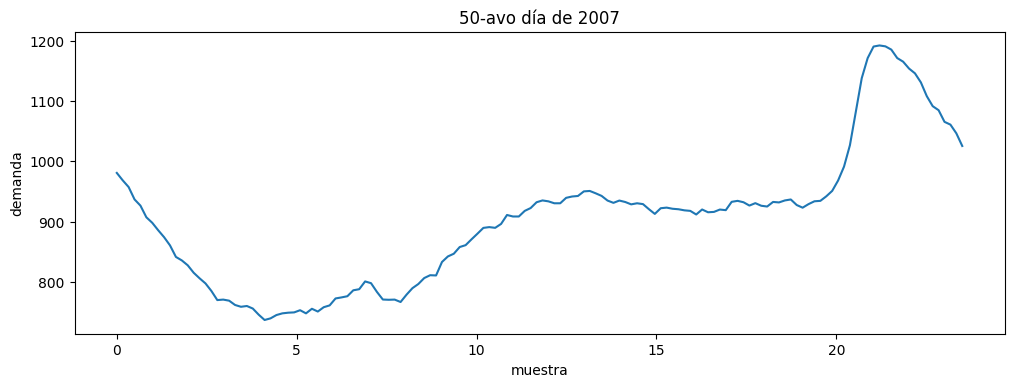

In [7]:
plt.figure(figsize=(12,4))
dem  = dem_data['AVGDEM'][50*144:51*144]
plt.plot(np.linspace(0,23.50,len(dem)),dem)
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('50-avo día de 2007')
plt.show()


### Demanda de una semana

Si miramos los datos de la primera semana, podemos observar un patrón cíclico claro, correspondiente a los siete días: hay 7 picos, y entre ellos se distingue un patrón que se repite casi de manera idéntica, salvo en las puntas, que corresponden a domingo y sábado respectivamente.


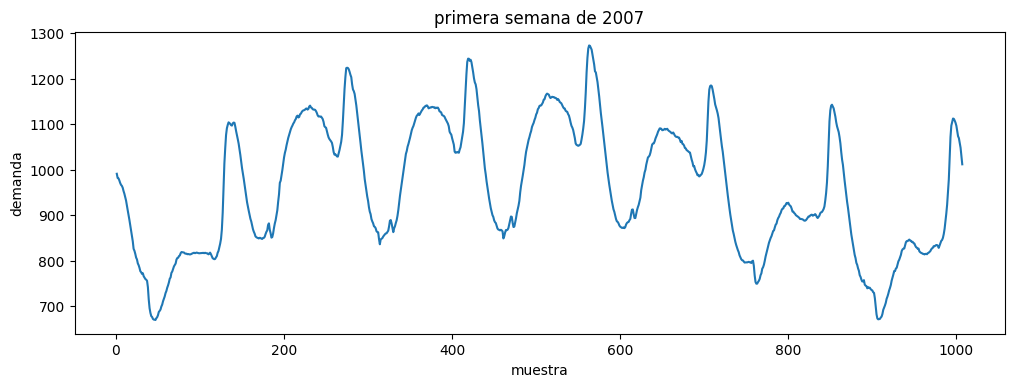

In [8]:
plt.figure(figsize=(12,4))
dem_data['AVGDEM'][:1008].plot()
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('primera semana de 2007')
plt.show()


### Demanda a lo largo de un mes

Si observamos los datos en un mes, vemos que hay también un patrón repetitivo asociado a las semanas: cada semana se comporta de manera muy similar a las otras. 

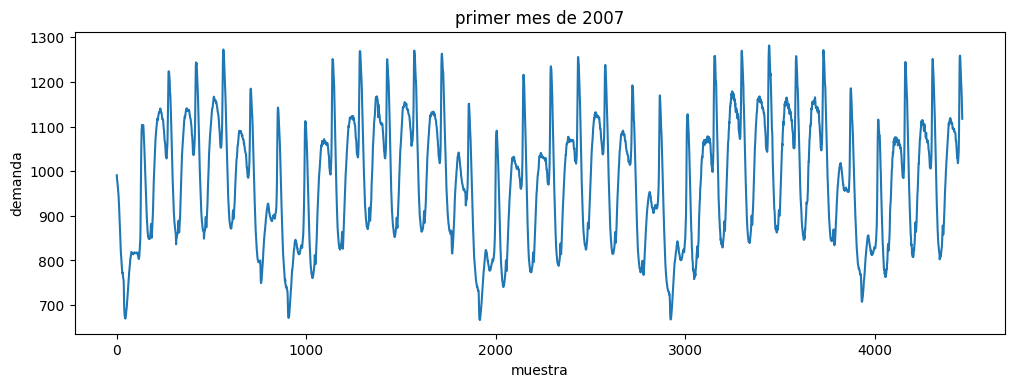

In [9]:
plt.figure(figsize=(12,4))
dem_data['AVGDEM'][:(144*31)].plot()
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('primer mes de 2007')
plt.show()

### Demanda durante varios años

La demanda a lo largo de un año también sigue un patrón que se repite año a año. Para ver esto, mostramos los datos de los 6 años que tenemos.

Si bien es más difícil ver el patrón aquí debido a las variaciones anteriores, aún es posible distinguirlo a simple vista. Por lo pronto, hay 6 picos y un patrón que se repite en torno a cada uno de ellos.

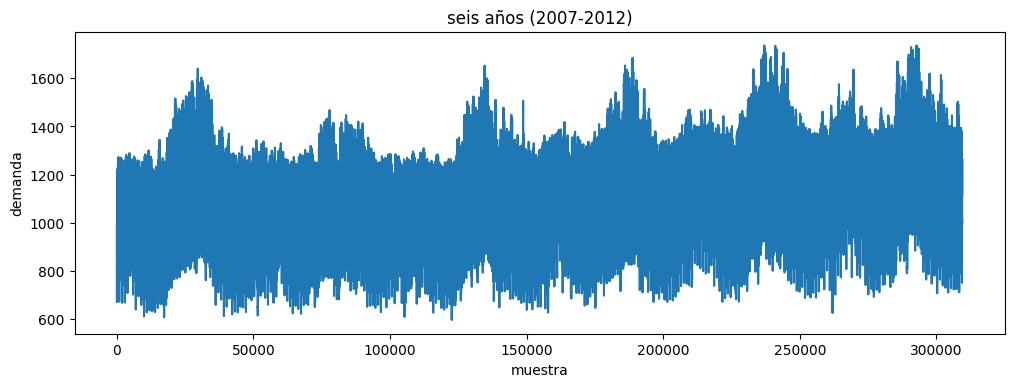

In [10]:
plt.figure(figsize=(12,4))
dem_data['AVGDEM'].plot()
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('seis años (2007-2012)')
plt.show()

### Tendencia

Vemos en la gráfica anterior que no sólo hay un patrón periódico que se repite cada año: a gran escala se observa también un aumento paulatino de la demanada con el correr de los años. Esta tendencia también debemos tenerla en cuenta.
 

### Sábados, domingos y feriados

Entre los distintos factores que afectan a la demanda, la actividad económica y el comportamiento de la población juegan un rol muy importante. Eso ya es obvio en los patrones diarios y semanales que observamos.
Es de esperar entonces que la demanda sea distinta dependiendo si el día es laborable o no, total o parcialmente. Los sábados y domingos son libres para mucha gente. Los feriados, también. Veamos si efectivamente es así. Para comprobarlo, tomaremos ahora unos cuantos ejemplos de distintos tipos de día, a ver si las diferencias son notorias. 

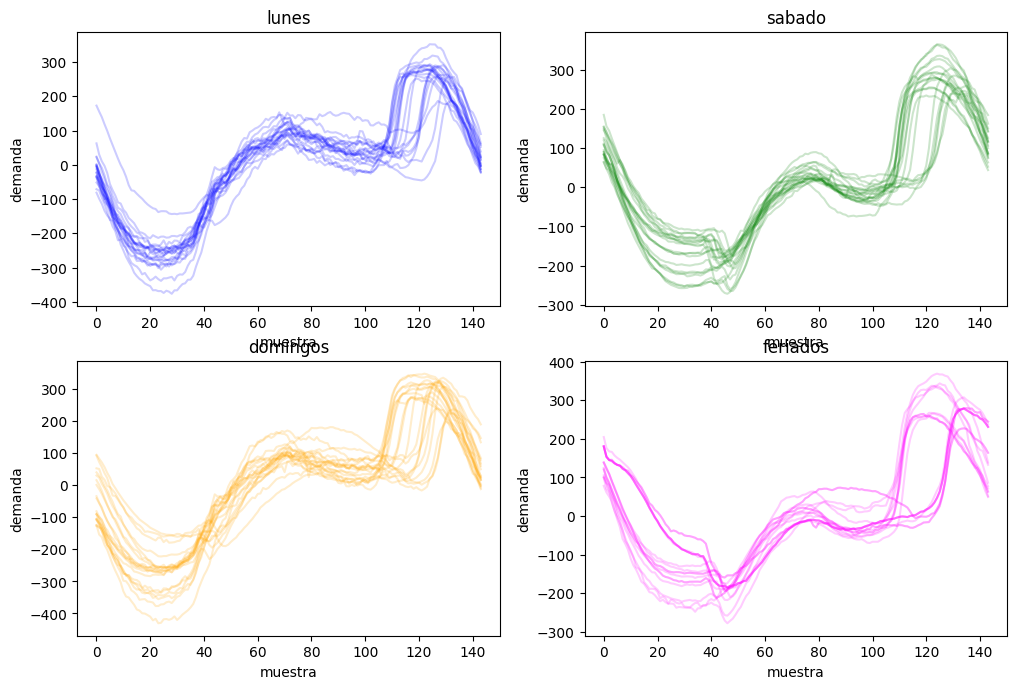

In [11]:
import numpy.random as rng

def get_demanda(datos,num_dia):
  return datos['AVGDEM'][num_dia*144:(num_dia+1)*144]

def get_feriado(datos,num_dia):
  return datos['HOLIDAY'][num_dia*144]

def get_diasem(datos,num_dia):
  return datos['ISODAY'][num_dia*144]


def get_dias_al_azar(datos,ndias,dia_sem,feriado):
  X = np.zeros((ndias,144))
  n = len(datos)//144
  for j in range(ndias):
    ok = False
    while not ok:
      d = rng.randint(n)
      dia = get_diasem(datos,d)
      if feriado is not None and feriado != get_feriado(datos,d):
        continue
      if dia_sem is not None and get_diasem(datos,d) != dia_sem:
        continue
      X[j,:] = get_demanda(datos,d)
      ok = True
  return X

rng.seed(123456)

luneses  = get_dias_al_azar(dem_data,20,2,False)
sabados  = get_dias_al_azar(dem_data,20,7,False)
domingos = get_dias_al_azar(dem_data,20,1,False)
feriados = get_dias_al_azar(dem_data,20,None,True)
#
# vamos a quitarle el valor medio para concentrarnos solo en el patron
# de variación horario
# nos conviene transponer los datos por cuestiones técnicas
#
luneses  = luneses.T  - np.mean(luneses,axis=1).T
sabados  = sabados.T  - np.mean(sabados,axis=1).T
domingos = domingos.T - np.mean(domingos,axis=1).T
feriados = feriados.T - np.mean(feriados,axis=1).T

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(luneses,color='blue',alpha=0.2)
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('lunes')

plt.subplot(2,2,2)
plt.plot(sabados,color='green',alpha=0.2)
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('sabado')

plt.subplot(2,2,3)
plt.plot(domingos,color='orange',alpha=0.2)
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('domingos')

plt.subplot(2,2,4)
plt.plot(feriados,color='magenta',alpha=0.2)
plt.xlabel('muestra')
plt.ylabel('demanda')
plt.title('feriados')

plt.show()


### Comentarios sobre los días

De  las gráficas anteriores podemos deducir:

1.   los lunes son siempre iguales y aburridos
1.   los sábados también son parecidos entre sí, y bastante distintos a los lunes
1.   los domingos son distintos a los lunes y a los domingos, y en general se parecen bastante entre sí, pero hay algún que otro caso raro
1.   los feriados también son distintos a los lunes, pero no son tan homogéneos: algunos se parecen a  sábados, otros a los domingos, y otros no se parecen a nada.

Lo último no debería sorprender, ya que es claro que los feriados son distintos según el día de la semana en que caigan. 




<a id="preprocesamiento"></a>
## Preprocesamiento

El mayor problema con los datos de este tipo son los _datos faltantes_. Por diversas razones, hay momentos en los que no puede tomarse una o varias medidas. Esto sucede con todas las medidas involucradas: demanda eléctrica, temperatura, radiación solar, viento, etc. 

Desafortunadamente, no siempre se dispone de información acerca de si una medida es válida o no: esto debe inferirse en base a los propios datos, y es una de las tareas más desafiantes en esta área de trabajo. En nuestro caso, esto ya está resuelto: el archivo que leimos, `demanda_2007_2012_pre1.csv`, ya tiene identificados los datos que son potencialmente inválidos. 

En general, la falta de datos se da en períodos de varias muestras consecutivas. Por ejemplo, si se rompe un medidor de temperatura, todas sus lecturas serán inválidas hasta que se arregle. Claramente, mientras más largo el período de la falla, peor será nuestra estimación de los datos que se perdieron. Si son muy pocos datos, por ejemplo dos, o tres, es posible obtener una muy buena estimación mediante una _interpolación_. Si más de, digamos, 5,  hay que recurrir a métodos más sofisticados.

Abajo vemos el resultado de _interpolar_  los datos de temperatura del día 5 de febrero de 2007. Ese es el día 1 de la semana 6 de 2007 (isoday 1, isoweek 6), por lo que lo vemos a partir de la posición $5{\times}7{\times}144$.

Los puntos grises son los datos que tenemos; ver que en varios lugares faltan datos. La curva naranja son los datos completados. Como se dijo, para estos casos sencillos, se obtienen muy buenos resultados utilizando métodos básicos de interpolación polinomial.



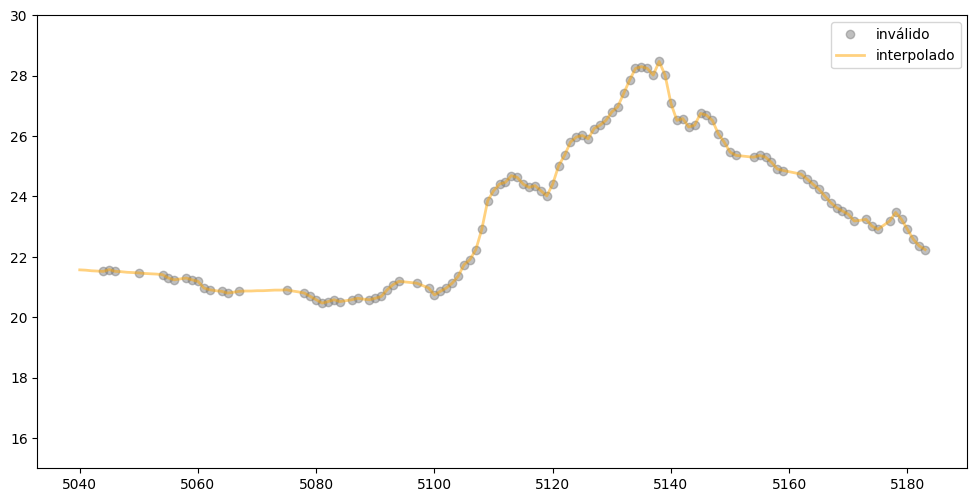

In [12]:
demanda_cruda = dem_data
#
# leemos el archivo corregido
#
with gzip.open('demanda_2007_2012_pre4.csv.gz',mode='rt') as gzfile:
  demanda = pd.read_csv(gzfile,delimiter='\t',na_values=('-100.00','-200.00'))
#
# marcamos los datos inválidos con 0's, para que se vean
#
#demanda_cruda['TEMP'][demanda_cruda['TEMP'] < 0] = 0
plt.figure(figsize=(12,6))
offset = 144*7*5
plt.plot(demanda_cruda['TEMP'][offset:(offset+144)],'o',label='inválido',lw=2,color='gray',alpha=0.5)
plt.plot(demanda['TEMP'][offset:(offset+144)],label='interpolado',color='orange',lw=2,alpha=0.5)
plt.ylim(15,30)
plt.legend()
plt.show()

<a id="modelado"></a>
# Modelado básico

Nuestro objetivo es el de proveer una buena predicción para la demanda de las próximas 24 horas en base a tres factores:

1.   los datos que tenemos hasta el día anterior
1.   la información de calendario disponible, incluyendo fecha, día de la semana, y si es feriado
1.   el pronóstico de temperatura para las próximas 24 horas

Por otro lado, la información a priori que tenemos es la siguiente:

1. peridicidad diaria
1. periodicidad semanal
1. periodicidad anual
1. tendencia creciente a lo largo del tiempo
1. los días feriados el comportamiento es distinto al de los días normales
1. la temperatura influye en el consumo (a través de calefacción y/o refrigeración); eso sí: no es claro cómo

En el paper mencionado al principio se describen varios métodos para atacar el problema. El método que vamos a ensayar aquí es distinto y hace uso de redes neuronales  cuya entrada son todos los datos anteriores. Para esto usaremos las funciones de `sklearn`  para entrenar redes neuronales "comunes".

Más precisamente, nos interesa estimar la salida de un día _entero_ dada toda la información disponible. Eso nos da una salida de dimensión $144$.

Claramente, no podemos entrenar una red neuronal que tome _todo_ el pasado en cuenta para la entrada. Lo que haremos es incorporar como entradas los datos de demanda y temperatura del día anterior al que queremos predecir. Esto son dos vectores adicionales de $144$ muestras cada uno.

El problema que tenemos ahora es que eso puede darnos una red demasiado grande, con demasiado detalle: no necsitamos la demanda estimada cada 10 minutos: alcanza con 1 hora. Podemos entonces simplificarnos mucho la vida si reducimos nuestros datos a una escala _horaria_. Así, pasamos a tener $24$ salidas para estimar, y poco más de $48$ entradas (24 temperaturas, 24 demandas, y datos de calendario).

Finalmente, nuestros datos están dados a una muestra diezminutal por fila. Necesitamos colapsar de a 144 filas en una sola muestra. Esto no es parte del modelado en sí, pero es necesario programar un poco para hacer esta transformación.



0.852500822771861


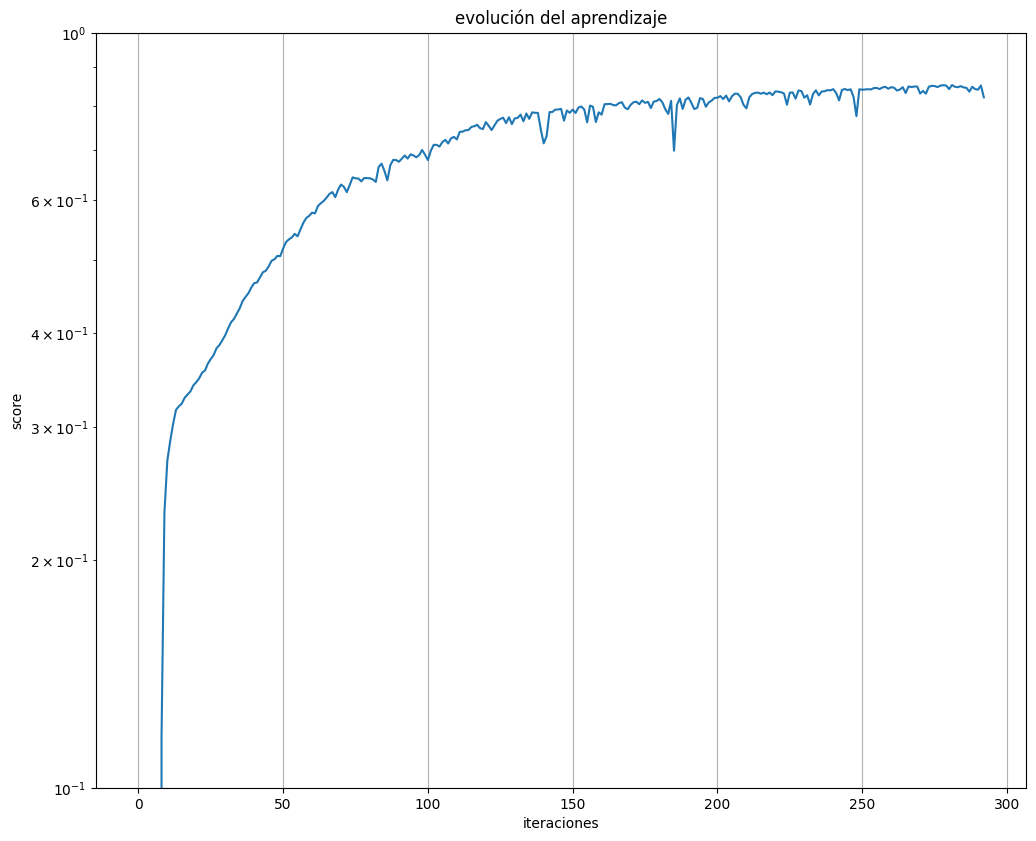

In [13]:
def transform_data(datos):
  #
  # 
  #
  nmuestras = len(datos)
  ndias     = nmuestras // 144
  nhoras    = 24
  #
  # promediamos 6 datos diezminutales en 1 de una hora
  #
  demanda   = datos['AVGDEM'] # 144 por dia
  Xdem      = np.array(demanda).reshape(ndias,nhoras,-1)
  Xdem      = np.mean(Xdem,axis=2)
  #
  # idem con la temperatura
  #
  temp      = datos['TEMP']   # 144 por dia
  Xtem      = np.array(temp).reshape(ndias,nhoras,-1)
  Xtem      = np.mean(Xtem,axis=2)
  #
  # nos quedamos con 1 dato de calendario por día
  #
  #
  # la hora no la usamos; ya está implícita en el índice de la demanda
  #
  Xday = np.array(datos['ISODAY']).reshape(ndias,-1)
  Xday = Xday[:,1].reshape(-1,1)
  Xsem = np.array(datos['ISOWEEK']).reshape(ndias,-1)
  Xsem = Xsem[:,1].reshape(-1,1)
  Xhol = np.array(datos['HOLIDAY']).reshape(ndias,-1)
  Xhol = Xhol[:,1].reshape(-1,1)

  #
  # armamos X con demandas, temperatura, y todo lo demás 
  #
  X = np.concatenate((Xdem[:-1,:],Xtem[:-1,:],Xday[1:,:],Xsem[1:,:],Xhol[1:,:]),axis=1)
  #
  # los X que podemos usar son los de todos los días menos el último (para el cual
  # no tenemos el dato del día siguiente)
  #

  # 
  # el vector de respuestas que buscamos es el de las 24 medidas del día siguiente
  #
  Y = Xdem[1:,:]
  return X, Y

X,Y = transform_data(demanda)

#
# evaluamos en el ultimo año
#
ndias_test = 365
ntest = ndias_test
n = X.shape[0]
ndias = n

X_train = X[:(n-ntest),:]
Y_train = Y[:(n-ntest),:]
X_test  = X[(n-ntest):,:]
Y_test  = Y[(n-ntest):,:]

# red neuronal para clasificación. MLP = Multi Layer Perceptron
from sklearn.neural_network import MLPRegressor
#
#
nnet = MLPRegressor(solver='adam', max_iter=1000, 
                    random_state=1234, 
                    learning_rate_init=1e-3,
                    hidden_layer_sizes=[250,50],
                    activation='relu',
                    batch_size=250,
                    early_stopping=True,tol=1e-5)
#
# ajustamos el modelo a los datos de entrenamiento
#
nnet.fit(X_train, Y_train)
plt.figure(figsize=(12,10))
plt.semilogy(nnet.validation_scores_)
plt.grid(True)
plt.xlabel('iteraciones')
plt.ylabel('score')
plt.title('evolución del aprendizaje')
plt.ylim(0.1,1.0)
print(nnet.best_validation_score_)


<a id="evaluacion"></a>
## Evaluación

Nuestro objetivo es estimar lo mejor posible la demanda instantánea. Para evaluar nuestros modelos, usaremos el _error proporcional absoluto medio_ (mean absolute proportional error, MAPE):

$$ \mathrm{MAPE} = \frac{100}{n}\sum_{j=1}^n\left|\frac{\hat{y}_j-y_j}{y_j}\right|$$

## Método de referencia -- Hong

Los métodos existentes para predecir demanda son muchos. Varios de ellos utilizan lo anterior, de diversas formas. Uno simple y razonablemente efectivo que se utiliza como _referencia_ o _benchmark_ en la evaluación de nuevos métodos es el llamado _Hong_. El método Hong es una regresión lineal multivariada en donde sólo juegan los datos de calendario y la temperatura, combinados de diversas formas. La fórmula en cuestión es:

$$ y_j = a_0 + a_1 j + a_2 d_j{\times}h_j + a_3 m_j + a_4 m_j{\times}t_j + a_5 m_j{\times}t_j^2 + a_6 m_j{\times}t_j^3 + a_7 h_j{\times}t_j + a_8 h_j{\times}t_j^2 + a_9 h_j{\times}t_j^3
$$

en donde $j$ es el índice temporal, $m$ es el mes del año, $d$ es el día de la semana, $h$ es la hora del día, y $t$ es la temperatura.

Lo primero que vamos a hacer entonces es construir este modelo de referencia mediante mínimos cuadrados en base a los datos que tenemos. Para eso calculamos un vector de características $\mathbf{x}_j$ de la siguiente manera:

$$\mathbf{x}_j =  (1,j,d_jh_j,m_j,m_jt,m_jt_j^2,m_jt_j^3,h_jt_j,h_jt_j^2,h_jt_j^3)$$

tomamos la demanda actual como $y_j$, y resolvemos el problema de regresión:

$$\mathbf{a}^* = \arg\min_{\mathbf{a}} \|\mathbf{Xa} - \mathbf{y}\|.$$



In [46]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

def convertir_a_horarios(datos,campo):
  return np.mean(np.array(datos[campo]).reshape(-1,6),axis=1)

def hong_features(datos):
  #
  # reducimos a frecuencia horaria, como hicimos con las redes
  #
  n = len(datos)//6
  c = np.ones(n)
  j = np.arange(n)
  m = np.array(datos['MON']-1)[::6]  # de 0 a 11
  h = np.array(datos['HOUR'])[::6]   
  d = np.array(datos['ISODAY']-1)[::6] # de 0 a 6
  t = convertir_a_horarios(datos,'TEMP')
  y = convertir_a_horarios(datos,'AVGDEM')
  X = np.zeros((n,10))
  X[:,0] = c
  X[:,1] = j
  X[:,2] = d*h
  X[:,3] = m
  X[:,4] = m*t
  X[:,5] = m*t**2
  X[:,6] = m*t**3
  X[:,7] = h*t
  X[:,8] = h*t**2
  X[:,9] = h*t**3
  return X,y



X,y = hong_features(demanda)
#
# reescalamos los datos para tener mejor condicionamiento
#
X = X / np.sqrt(np.mean(X**2,axis=0))

ntest = 365*24
X_train_hong = X[:-ntest,:]
y_train_hong = y[:-ntest]

X_test_hong = X[-ntest:,:]
y_test_hong = y[-ntest:]

hong = Lasso(alpha=1e-6)
res = hong.fit(X_train_hong,y_train_hong)
ypred_hong = hong.predict(X_test_hong)
yerr_hong  = ypred_hong - y_test_hong

print("\n==============================\n")

print("RESULTADOS PRIMARIOS:\n")
print("\tMODELO HONG:")
print('\t\tMAPE:',np.round(100*np.mean(np.abs(yerr_hong/y_test_hong)),2),'%')

Ypred_nnet = nnet.predict(X_test)
Yerr_nnet  = Ypred_nnet - Y_test
ypred_nnet  = Ypred_nnet.ravel()
yerr_nnet  = Yerr_nnet.ravel()

print("\n\tMODELO NEURONAL:")
print('\t\tMAPE:',np.round(100*np.mean(np.abs(yerr_nnet/y_test_hong)),2),'%')

print("\n==============================\n")




RESULTADOS PRIMARIOS:

	MODELO HONG:
		MAPE: 12.19 %

	MODELO NEURONAL:
		MAPE: 3.64 %




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.734e+08, tolerance: 1.543e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Inspección de los resultados

Bueno! Nuestro modelo neuronal, sin muchas vueltas, dio en principio muchísimo mejor que el de Hong. 

Es cierto que el modelo de Hong es muy sencillo, y no toma en cuenta cosas como los feriados. Sin embargo, el modelo de Hong tiene una gran ventaja: utiliza la información de temperatura del mismo día que se desea estimar la demanda. En ese sentido, Hong ni siquiera es un modelo predictivo. Lo sería si se basara en pronósticos de temperatura, pero ese no es nuestro caso.

En contraste, el modelo neuronal sólo utiliza información del día previo. Es un modelo realmente predictivo.

Ahora, lo que realmente interesa es ver el desempeño diario. Las medidas que tomamos anteriormente eran globales. Vamos a calcular ahora el MAPE para cada dia del último año, y graficarlo para cada método.

Luego vamos a elegir 5 casos representativo de cada método: el peor día (percentil 100 de error), el percentil 75, el 50 (mediana), el 25 y el mejor día (percentil 0 de error).




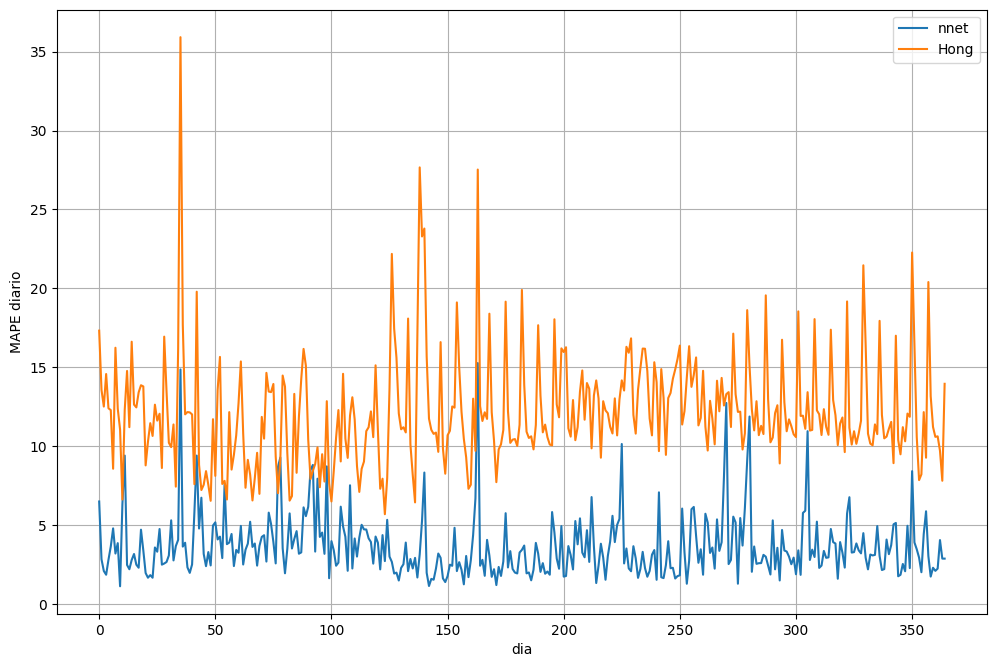

In [47]:
Ypred_hong = np.reshape(ypred_hong,(-1,24))
Yerr_hong = yerr_hong.reshape(-1,24)
mape_net  = 100*np.mean(np.abs(Yerr_nnet/Y_test),axis=1)
mape_hong = 100*np.mean(np.abs(Yerr_hong/Y_test),axis=1)
plt.figure(figsize=(12,8))
plt.plot(mape_net,label='nnet')
plt.plot(mape_hong,label='Hong')
plt.grid(True)
plt.xlabel('dia')
plt.ylabel('MAPE diario')
plt.legend()
plt.show()

## Mejores y peores resultados

Veamos ahora los mejores y los peores días en detalle.


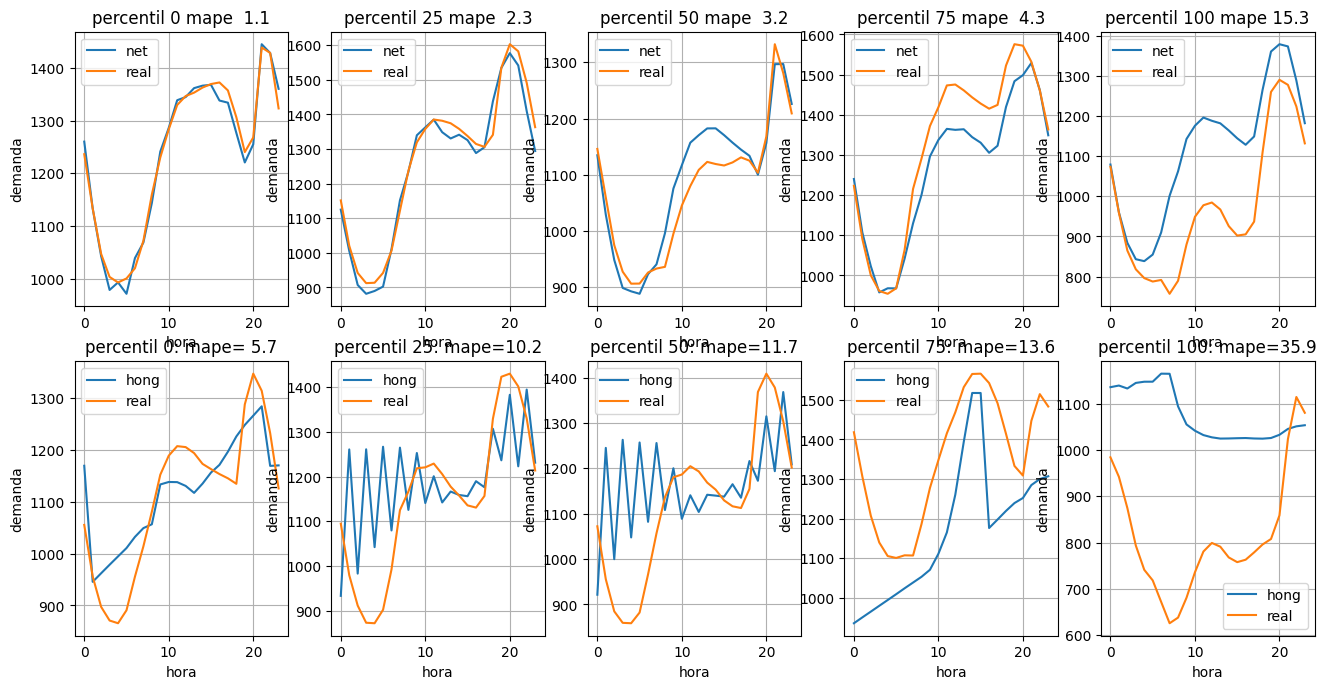

In [48]:
net_idx  = np.argsort(mape_net)
hong_idx = np.argsort(mape_hong)
n = len(net_idx)

plt.figure(figsize=(16,8))
j = 1
for p in (0,25,50,75,100):
  rank = p*(n-1)//100
  idx = net_idx[rank]
  mape = mape_net[idx]

  net = Ypred_nnet[idx,:]
  ref = Y_test[idx,:]
  plt.subplot(2,5,j)
  plt.plot(net,label='net')
  plt.plot(ref,label='real')
  plt.grid(True)
  plt.xlabel('hora')
  plt.ylabel('demanda')
  plt.title(f'percentil {p} mape {mape:4.1f}')
  plt.legend()
  j = j + 1

for p in (0,25,50,75,100):
  rank = p*(n-1)//100
  mape=mape_hong[hong_idx[rank]]
  hong = Ypred_hong[hong_idx[rank],:]
  ref = Y_test[hong_idx[rank],:]
  plt.subplot(2,5,j)
  plt.plot(hong,label='hong')
  plt.plot(ref,label='real')
  plt.grid(True)
  plt.xlabel('hora')
  plt.ylabel('demanda')
  plt.title(f'percentil {p}: mape={mape:4.1f}')
  plt.legend()
  j = j + 1
plt.show()


### Desempeño según tipo de día

Vamos ahora a distinguir el desempeño según los tipos de día que observamos:

*   dia de semana
*   fin de semana
*   feriado


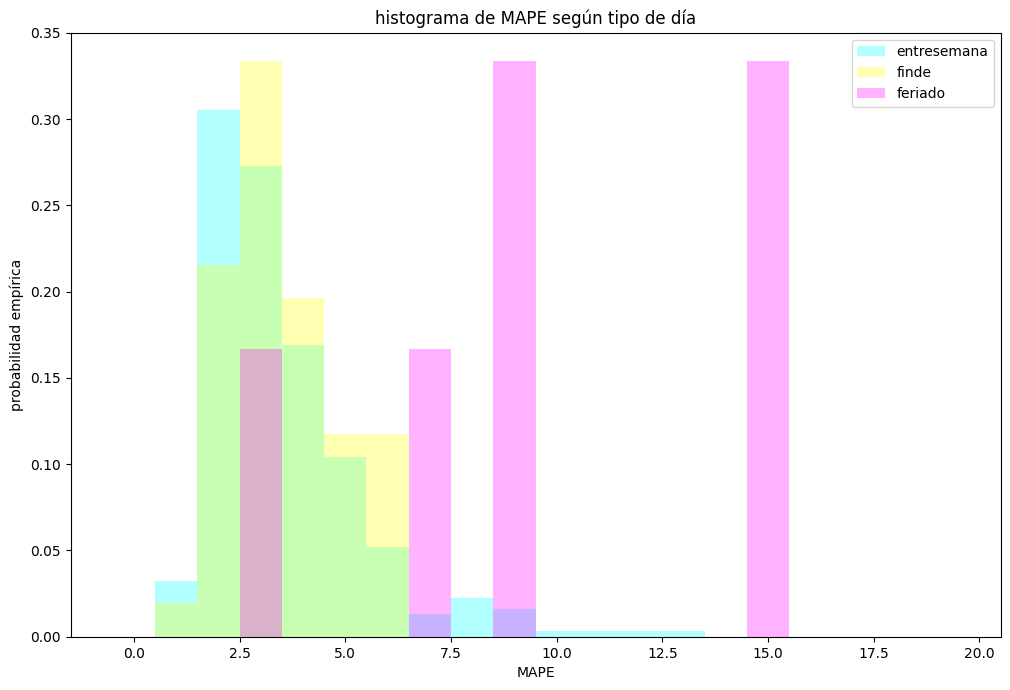

In [49]:
diasem_test = X_test[:,-3] 
hol_test    = X_test[:,-1].astype(bool)
finde_test  = np.logical_or(np.equal(diasem_test,0),np.equal(diasem_test,6))
finde_test  = np.logical_and(finde_test,np.logical_not(hol_test))
comun_test  = np.logical_and(np.logical_not(finde_test),np.logical_not(hol_test))

#Y_test_finde = Y_test[finde_test,:]
#Y_test_comun = Y_test[comun_test,:]
#Y_test_hol   = Y_test[hol_test,:]

mape_finde = mape_net[finde_test]
mape_comun = mape_net[comun_test]
mape_hol   = mape_net[hol_test]

plt.figure(figsize=(12,8))
bins = np.arange(-0.5,20,1)
plt.hist(mape_comun,bins,alpha=0.3,color='cyan',label='entresemana',density=True)
plt.hist(mape_finde,bins,alpha=0.3,color='yellow',label='finde',density=True)
plt.hist(mape_hol,bins,alpha=0.3,color='magenta',label='feriado',density=True)
plt.legend()
plt.xlabel('MAPE')
plt.ylabel('probabilidad empírica')
plt.title('histograma de MAPE según tipo de día')
plt.show()



Los tres histogramas nos muestran algo que ya podíamos prever en la visualización inicial: los días feriados son más difíciles de modelar que los otros, y los días de semana son los más predecibles. Claro que hay excepciones: hay un día feriado que es predicho muy bien, y hay al menos un día de semana  que tuvo una muy mala predicción. Cabe recordar que en 2012 fueron los juegos olímpicos de Londres. Es posible que algún evento importante relacionado a los Juegos Olímpicos haya ocurrido entresemana, distorsionando así el comportamiento habitual de la población. 

## Comentarios finales

Los resultados obtenidos son extremadamente buenos, más teniendo en cuenta que se obtuvieron de manera casi automática, con una red neuronal, sin aplicar mucho conocimiento a priori. Si bien el modelo _mezcla_ que se describe en [[CCMR2018]](#CCMR2018) da mejores resultados en casi todos los casos que el neuronal, ninguno de los modelos individuales descritos allí, varios de ellos bastante sofisticados, tienen un desempeño tan bueno como el que obtuvimos aquí con una red neuronal, casi sin ajustar sus hiperparámetros parámetros (de todos modos, cabe notar que los resultados no son sobre el mismo año).



# Referencias

<a id="CCMR2018">CCMR2018</a>
Castrillejo A., Cugliari J., Massa F., Ramirez I. (2018) Electricity Demand Forecasting: The Uruguayan Case. Renewable Energy: Forecasting and Risk Management. FRM 2017. Springer Proceedings in Mathematics & Statistics, vol 254. Springer, Cham. https://doi.org/10.1007/978-3-319-99052-1_6.
 [PREPRINT](https://hal.archives-ouvertes.fr/hal-01787143/document).
